In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np

pygame 2.6.0 (SDL 2.28.4, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
def getDQN(input_shape):
    input = tf.keras.layers.Input(shape = (input_shape, ))
    out = tf.keras.layers.Dense(64, activation = 'relu')(input)
    out = tf.keras.layers.Dense(64, activation = 'relu')(out)
    output = tf.keras.layers.Dense(3, activation = 'softmax')(out)
    model = tf.keras.Model(input, output)
    return model

In [5]:
import pygame
import random
import numpy as np
from collections import namedtuple
from enum import Enum

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple("Point", "x, y")

# rgb colors
WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)

BLOCK_SIZE = 60
SPEED = 120

class SnakeGameEnvironment:

    def __init__(self, width=360, height=360, playerName="Player", visualize=False):
        self.w = width
        self.h = height
        self.playerName = playerName
        self.visualize = visualize

        # Initialize display and font only if visualization is enabled
        if self.visualize:
            pygame.display.init()
            pygame.font.init()
            self.display = pygame.display.set_mode((self.w, self.h))
            pygame.display.set_caption("Silly Snake")
            self.font = pygame.font.Font(pygame.font.get_default_font(), 25)
        self.clock = pygame.time.Clock()

        # init game
        self.reset()
        self.initial_state = self.getState()

    def reset(self):
        self.direction = Direction.RIGHT
        self.head = Point(self.w / 2, self.h / 2)
        self.snake = [self.head,
                      Point(self.head.x - BLOCK_SIZE, self.head.y),
                      Point(self.head.x - (2 * BLOCK_SIZE), self.head.y)]

        self.score = 0
        self.food = None

        self.placeFood()

        self.frameIteration = 0

    def placeFood(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self.placeFood()

    def playStep(self, action):
        self.frameIteration += 1

        if self.visualize:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()

        # Move the snake
        self.moveSnake(action)
        reward = 0

        # Check for collisions
        if self.isCollision() or self.frameIteration > 100 * len(self.snake):
            gameOver = True
            reward -= 10
            state = self.getState()
            return state, reward, gameOver, self.score

        # Check if the snake has eaten the food
        if self.head == self.food:
            self.score += 1
            reward = 10
            self.placeFood()
        else:
            self.snake.pop()

        # Update UI and clock only if visualization is enabled
        if self.visualize:
            self.updateUi()
            self.clock.tick(SPEED)

        gameOver = False
        state = self.getState()

        return state, reward, gameOver, self.score

    def getState(self):
        head = self.snake[0]
        food = self.food

        # Get the relative positions of food to the snake's head
        foodDirection = (np.sign(food.x - head.x), np.sign(food.y - head.y))

        # Get danger information (if there's a collision in the next move in each direction)
        danger_straight = self.isCollision(self.nextPoint(self.direction))
        danger_right = self.isCollision(self.nextPoint(Direction((self.direction.value % 4) + 1)))
        danger_left = self.isCollision(self.nextPoint(Direction((self.direction.value - 2) % 4 + 1)))

        state = [
            danger_straight,
            danger_right,
            danger_left,
            self.direction == Direction.RIGHT,
            self.direction == Direction.LEFT,
            self.direction == Direction.UP,
            self.direction == Direction.DOWN,
            foodDirection[0],
            foodDirection[1],
        ]

        return np.array(state, dtype=int)

    def nextPoint(self, direction):
        x = self.head.x
        y = self.head.y

        if direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif direction == Direction.UP:
            y -= BLOCK_SIZE

        return Point(x, y)

    def isCollision(self, p: Point = None):
        if p is None:
            p = self.head

        # Check if it hits border
        if p.x > self.w - BLOCK_SIZE or p.x < 0:
            return True

        if p.y > self.h - BLOCK_SIZE or p.y < 0:
            return True

        # Check if it hits itself
        if p in self.snake[1:]:
            return True

        return False

    def moveSnake(self, action):
        # action -> [straight, right, left]
        clockWiseDirections = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        currentDirectionIndex = clockWiseDirections.index(self.direction)

        newDirection = self.direction

        if np.array_equal(action, [0, 1, 0]):   # right
            newDirection = clockWiseDirections[(currentDirectionIndex + 1) % 4]
        elif np.array_equal(action, [0, 0, 1]): # left
            newDirection = clockWiseDirections[(currentDirectionIndex - 1) % 4]

        self.direction = newDirection

        x = self.head.x
        y = self.head.y

        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

        # This grows the size of our snake
        self.snake.insert(0, self.head)

    def updateUi(self):
        self.display.fill(BLACK)

        for p in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(p.x, p.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(p.x + 4, p.y + 4, 12, 12))

        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        scoreText = self.font.render("Score: " + str(self.score) + " Speed: " + str(SPEED) + " Player: " + self.playerName, True, WHITE)

        self.display.blit(scoreText, [0, 0])

        pygame.display.flip()

    def setPlayerName(self, name):
        self.playerName = name


In [6]:
env = SnakeGameEnvironment(playerName = "DQN_RL", visualize = True)

2024-08-08 06:45:59.326 Python[3211:48083298] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


In [7]:
state_shape = env.initial_state.shape[0]

In [8]:
dqn_model = getDQN(input_shape = state_shape)
target_model = copy(dqn_model)
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [93]:
episodes = 10000
epsilon = 1
eps_decay = 0.995
min_eps = 0.1
max_buffer_size = 500
gamma = 0.95
buffer = []
action_space = [[1, 0 , 0], [0, 1, 0], [0, 0, 1]]

In [10]:
action_space[0]

[1, 0, 0]

In [11]:
action_space[np.random.choice(len(action_space))]

[0, 0, 1]

In [12]:
target_model.load_weights("DQN_SNAKE-60-360-360.weights.h5")
dqn_model.load_weights("DQN_SNAKE-60-360-360.weights.h5")

In [118]:
epsilon = 0.1
min_eps = 0.05

In [ ]:
total_reward_history = []
loss_history = []
for i in range(episodes):
    env.reset()
    gameOver = False
    curr_state = env.initial_state
    action_history = [0, 0, 0]
    exploration_exploitation = [0, 0]
    total_loss = 0
    total_reward = 0
    reward_history = []
    

    while not gameOver:
        random_num = np.random.uniform(0, 1)
        if random_num < epsilon:
            action = np.random.choice(len(action_space))
            action_history[action] += 1
            exploration_exploitation[0] += 1
        else:
            action = np.argmax(target_model.predict(curr_state.reshape((-1, state_shape)), verbose = 0))
            action_history[action] += 1
            exploration_exploitation[1] += 1
        next_state, reward, gameOver, curr_score = env.playStep(action_space[action])

        quadruple = (curr_state, action, reward, next_state, gameOver)
        buffer.append(quadruple)
        if len(buffer) > max_buffer_size:
            buffer.pop(0)
        curr_state = next_state

        reward_history.append(reward)
        total_reward += reward

        if env.visualize:
            env.updateUi()
    
    random_indices = np.random.choice(len(buffer), min(len(buffer) - 1, 50), replace = False)
    sampled_quadruples = [buffer[int(random_index)] for random_index in random_indices]

    for quad in sampled_quadruples:
        curr_state, action, reward, next_state, gameOver = quad
        next_q_val = np.max(target_model.predict(next_state.reshape((-1, state_shape)), verbose = 0))
        if gameOver:
            target_q_val = reward
        else:
            target_q_val = reward + gamma * next_q_val
        
        with tf.GradientTape() as tape:
            curr_q = dqn_model(curr_state.reshape((-1, state_shape)), training = True)
            target_q = copy(curr_q)
            target_q = target_q.numpy()
            target_q[0][np.argmax(curr_q)] = target_q_val
            tagrte_q = tf.convert_to_tensor(target_q)
            loss = tf.reduce_sum(tf.keras.ops.square(target_q - curr_q))
        grads = tape.gradient(loss, dqn_model.trainable_variables)
        optimiser.apply_gradients(zip(grads, dqn_model.trainable_variables))
        total_loss += loss

    total_loss /= len(sampled_quadruples)
    loss_history.append(total_loss)
    total_reward_history.append(total_reward)

    epsilon = max(epsilon * eps_decay, min_eps)

    if i % 5 == 0:
        target_model.set_weights(dqn_model.get_weights())
    
    if i % 50 == 0:
        target_model.save_weights("DQN_SNAKE-60-360-360.weights.h5")

    print(i, "-> LOSS->", total_loss, "-> Reward->", total_reward, "-> SCORE->", env.score)
    print("ACTION->", action_history, "-> EXPLORATION->", exploration_exploitation)

            

In [121]:
target_model.save_weights("BEST_DQN_SNAKE-60-360-360.weights.h5")

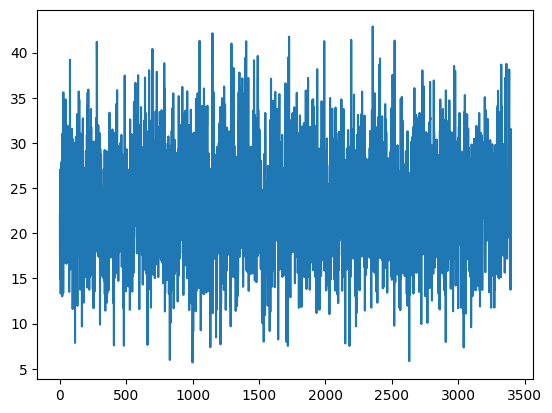

In [122]:
plt.plot(loss_history)

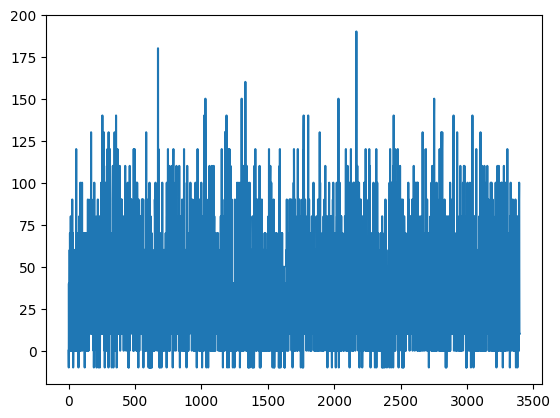

In [123]:
plt.plot(total_reward_history)

In [132]:
env.reset()
gameOver = False
curr_state = env.initial_state
total_reward = 0

while not gameOver:

    action = np.argmax(target_model.predict(curr_state.reshape((-1, state_shape)), verbose = 0))
    action_history[action] += 1
    next_state, reward, gameOver, curr_score = env.playStep(action_space[action])
    curr_state = next_state
    total_reward += reward

    if env.visualize:
        env.updateUi()

In [133]:
print(total_reward)
print(action_history)

90
[201, 70, 72]
